# CellAssign results

Notebook showing cellAssign results with new taxonomy from Nick.

`cell_types` composed in https://github.com/NIH-CARD/brain-taxonomy

```python
cell_types = [
    "oligo",
    "opc",
    "glutamatergic",
    "gabergic",
    "protoplasmic_astrocyte",
    "fibrous_astrocyte",
    "microglia",
    "t_cell",
    "b_cell",
    "pericyte",
    "endothelial",
    "unknown",
]
```

----


Outline:

- setup:  imports, helper_functions, data path definitions
- get predictions (fit `cellassign` model)
- assess predictions
    - clean vs. full set of samples
    - cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
    - repititions / seeds


## setup  
- imports 
- helper_functions 
- data path definitions

In [1]:
import sys
import os

import scanpy as sc
import anndata as ad
from pathlib import Path
import scipy.sparse as sp
import pandas as pd
import numpy as np
import scvi

# %%
from sklearn.metrics import precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt


sys.path.append(os.path.abspath(".."))


In [2]:
XYLENA2_RAW_PATH = "data/scdata/xylena_raw"
XYLENA2_PATH = "data/scdata/xylena"

# FULL data is both "clean" (train+test) and "dirty" samples which were originally left out of the dataset
XYLENA2_FULL = "xyl2_full.h5ad"


CELLASSIGN_FULL_MARKERS_TABLE = "cellassign_full_markers.csv"
CELLASSIGN_SIMPLE1_MARKERS_TABLE = "cellassign_simple_markers.csv"
CELLASSIGN_SIMPLE2_MARKERS_TABLE = "cellassign_simple_no_unknown_markers.csv"
CELLASSIGN_XYLENA_MARKERS_TABLE = "cellassign_xylena_markers.csv"



In [4]:
root_path = Path.cwd().parent
data_path = root_path / XYLENA2_PATH
raw_data_path = root_path / XYLENA2_RAW_PATH
root_path


PosixPath('/home/ergonyc/Projects/SingleCell/labelator')

In [5]:

tax_path = root_path.parent / "brain-taxonomy/markers"
markers_path = tax_path / CELLASSIGN_XYLENA_MARKERS_TABLE
markers = pd.read_csv(markers_path, index_col=0)

FileNotFoundError: [Errno 2] No such file or directory: '/home/ergonyc/Projects/SingleCell/brain-taxonomy/markers/cellassign_xylena_markers.csv'

In [6]:
# helper functions
def get_cell_types(adata, markers, batch_key=None, noise=None, seed=9627):
    """ """
    #  2. copy for cellassign
    # bdata = adata[:, markers.index].copy() #
    bdata = adata[:, adata.var.index.isin(markers.index)].copy()

    #  3. get size_factor and noise .  NOTE: it is imperitive to compute lib_size on the full data
    lib_size = adata.X.sum(1)  # type: ignore
    bdata.obs["size_factor"] = lib_size / np.mean(lib_size)

    #  4. model = CellAssign(bdata, marker_genes)
    scvi.external.CellAssign.setup_anndata(
        bdata,
        size_factor_key="size_factor",
        # batch_key="sample",
        batch_key=batch_key,
        layer=None,  #'counts',
        continuous_covariate_keys=noise,
    )

    #  5. model.train()
    # NOTE: highly dependent on seed... which may be a way for us to estimate the uncertainty of the ground truth prediction
    scvi.settings.seed = seed
    model = scvi.external.CellAssign(bdata, markers)
    model.train()  # use default training parameters

    #  6. model.predict()
    preds = model.predict()
    preds["cellassign_types"] = preds.idxmax(axis=1).values

    if "cell_type" not in bdata.obs_keys():
        preds["cell_type"] = "NONE"
    else:
        preds["cell_type"] = bdata.obs["cell_type"].values
    preds["sample"] = bdata.obs["sample"].values
    preds["cell"] = bdata.obs.index.values
    preds.index = preds["cell"].values

    return preds, model


def plot_confusion(
    df: pd.DataFrame,
    title_caption: str = "Confusion matrix",
    pred_key: str = "cellassign_types_A",
    cell_type_key: str = "cellassign_types_B",
):
    """Plot confusion matrix of predictions. This version is slooooow (6 seconds)

    Parameters
    ----------
    adata : AnnData
        Annotated data matrix.
    pred_key : str
        Key in `adata.obs` where predictions are stored. Default is `pred`.
    cell_type_key : str
        Key in `adata.obs` where cell types are stored. Default is `cell_type`.
    model_name : str
        Name of model. Default is `LBL8R`.
    title_str : str
        Additional string to add to title. Default is `""`.
    fig_dir : Path | str
        Directory to save figure to. Default is `None`.

    Returns
    -------
    None

    """
    # Calculate precision, recall, and F1-score
    prec = precision_score(df[cell_type_key], df[pred_key], average="macro")
    rec = recall_score(df[cell_type_key], df[pred_key], average="macro")
    f1 = f1_score(df[cell_type_key], df[pred_key], average="macro")
    acc = (df[pred_key] == df[cell_type_key]).mean()
    confusion_matrix = pd.crosstab(
        df[pred_key],
        df[cell_type_key],
        rownames=[f"Prediction {pred_key}"],
        colnames=[f"Ground truth {cell_type_key}"],
    )
    confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)
    fig, ax = plt.subplots(figsize=(5, 4))
    sns.heatmap(
        confusion_matrix,
        cmap=sns.diverging_palette(245, 320, s=60, as_cmap=True),
        ax=ax,
        square=True,
        cbar_kws=dict(shrink=0.4, aspect=12),
    )
    title_str = f"{acc=:3f}:  {prec=:3f}: {rec=:3f}: {f1=:3f})"
    ax.set_title(title_str.split(":"))
    plt.suptitle(title_caption)
    plt.tight_layout()


# %%


def print_count_subset(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )
    key = f"{labs[1]}pct_"
    summary[key] = (
        100
        * merged_predictions.cellassign_types_B.value_counts()
        / merged_predictions.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}_"
    summary[key] = merged_predictions.cellassign_types_B.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(f"   (underscore `_` indicates samples matched to {labs[0]} samples)")
    print(summary)

    return summary


def print_count_group(
    predictionsA: pd.DataFrame, predictionsB: pd.DataFrame, labs: list = ["A", "B"]
):

    summary = pd.DataFrame()
    key = f"{labs[0]}pct"
    summary[key] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    key = f"{labs[1]}pct"
    summary[key] = (
        100 * predictionsB.cellassign_types.value_counts() / predictionsB.shape[0]
    )

    key = f"{labs[0]}"
    summary[key] = predictionsA.cellassign_types.value_counts()
    key = f"{labs[1]}"
    summary[key] = predictionsB.cellassign_types.value_counts()

    print(
        f" N samples {labs[0]}= {predictionsA.shape[0]}, N samples {labs[1]}= {predictionsB.shape[0]}"
    )
    print(summary)

    return summary

## get predictions
fit `cellasign` model

> (skipping) `retrain=False`


In [7]:
retrain = False

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################

if retrain:

    filen = data_path / XYLENA2_FULL
    adata = ad.read_h5ad(filen)

    # In[ ]:
    train_test_samp = adata.obs["train"] | adata.obs["test"]

    for samp_set in ["full"]:  # ["full", "clean"]:
        bdata = adata[train_test_samp] if samp_set == "clean" else adata

        for rep in range(7):  # [0,1,2,3,4] have different seeds  [5,6,7] are the same
            
            if rep >2:
                seed = 9627
            else:
                seed = rep
            
            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=noise, seed=seed
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
            model.save(modelname, overwrite=True)

            predictions, model = get_cell_types(
                bdata, markers, batch_key="sample", noise=None, seed=seed
            )

            filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
            predictions.reset_index(drop=True).to_feather(filen)

            modelname = root_path / f"{samp_set}{rep}_cellassign"
            model.save(modelname, overwrite=True)

In [ ]:
# still need [5,6] noise (seed = 9625)
retrain = True
samp_set = "full"

noise = ["doublet_score", "pct_counts_mt", "pct_counts_rb"]  # aka "noise"

########################
# 0. LOAD TRAIN DATA
########################
filen = data_path / XYLENA2_FULL
adata = ad.read_h5ad(filen)



Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 123/400:  31%|███       | 123/400 [36:19<1:21:48, 17.72s/it, v_num=1, train_loss_step=18.4, train_loss_epoch=14.4]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 14.392. Signaling Trainer to stop.


NameError: name 'samp_set' is not defined

In [14]:

samp_set = "full"

# In[ ]:
bdata = adata
for rep in [6]:  
            
    seed = 9627
            
    predictions, model = get_cell_types(
        bdata, markers, batch_key="sample", noise=noise, seed=seed
    )

    filen = root_path / "testing" / f"{samp_set}{rep}_noise_predictions.feather"
    predictions.reset_index(drop=True).to_feather(filen)

    modelname = root_path / f"{samp_set}{rep}_noise_cellassign"
    model.save(modelname, overwrite=True)

bdata = adata
# need [0,1,2] non-noise
for rep in [0,1,2]:  
    seed = rep

    predictions, model = get_cell_types(
        bdata, markers, batch_key="sample", noise=None, seed=seed
    )

    filen = root_path / "testing" / f"{samp_set}{rep}_predictions.feather"
    predictions.reset_index(drop=True).to_feather(filen)

    modelname = root_path / f"{samp_set}{rep}_cellassign"
    model.save(modelname, overwrite=True)




Seed set to 9627
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 123/400:  31%|███       | 123/400 [36:32<1:22:17, 17.83s/it, v_num=1, train_loss_step=18.4, train_loss_epoch=14.4]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 14.392. Signaling Trainer to stop.


Seed set to 0
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 96/400:  24%|██▍       | 96/400 [27:01<1:25:36, 16.90s/it, v_num=1, train_loss_step=14.4, train_loss_epoch=14.3]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 14.306. Signaling Trainer to stop.


Seed set to 1
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 95/400:  24%|██▍       | 95/400 [27:13<1:27:22, 17.19s/it, v_num=1, train_loss_step=12.9, train_loss_epoch=14.3]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 14.327. Signaling Trainer to stop.


Seed set to 2
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.
/opt/conda/envs/gcp/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=17` in the `DataLoader` to improve performance.


Epoch 87/400:  22%|██▏       | 87/400 [28:43<1:43:19, 19.81s/it, v_num=1, train_loss_step=11.4, train_loss_epoch=14.3]
Monitored metric elbo_validation did not improve in the last 15 records. Best score: 14.317. Signaling Trainer to stop.


In [12]:
scib_metrics.__version__

'0.5.1'

In [8]:
# still need [5,6] noise (seed = 9625)

# move full?_predictions 0,1,2 to 4,5,6

# need [0,1,2] non-noise

sys.version

'3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 10:40:35) [GCC 12.3.0]'

## assess predictions

compare:    
- clean vs. full set of samples
- cellassign "noise" parameter:  `continuous_covariate_keys=["doublet_score", "pct_counts_mt", "pct_counts_rb"]` vs `None`
- repititions / seeds

### Full and Clean sets  vanilla vs. continuous_covariates ("_noise")

 N samples full0_noise= 2012744, N samples full0= 2012744
                  full0_noisepct   full0pct  full0_noise   full0
cellassign_types                                                
ExN                    37.250291  36.945434       749753  743617
Oligo                  36.490830  36.631882       734467  737306
Astro                   8.295044   8.401963       166958  169110
InN                     7.609810   7.760152       153166  156192
OPC                     5.921916   5.822449       119193  117191
MG                      4.061570   4.071159        81749   81942
VC                      0.370539   0.366962         7458    7386


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full1= 2012744
                  full1_noisepct   full1pct  full1_noise   full1
cellassign_types                                                
ExN                    37.251682  36.929982       749781  743306
Oligo                  36.503847  36.630689       734729  737282
Astro                   8.304235   8.421687       167143  169507
InN                     7.608419   7.759308       153138  156175
OPC                     5.912525   5.818326       119004  117108
MG                      4.048553   4.072947        81487   81978
VC                      0.370738   0.367061         7462    7388


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full2= 2012744
                  full2_noisepct   full2pct  full2_noise   full2
cellassign_types                                                
ExN                    37.241547  36.899129       749577  742685
Oligo                  36.505388  36.645147       734760  737573
Astro                   8.305179   8.426109       167162  169596
InN                     7.636987   7.761891       153713  156227
OPC                     5.888230   5.822201       118515  117186
MG                      4.051683   4.079158        81550   82103
VC                      0.370986   0.366366         7467    7374


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full3= 2012744
                  full3_noisepct   full3pct  full3_noise   full3
cellassign_types                                                
ExN                    39.632959  39.311656       797710  791243
Oligo                  36.528590  36.668747       735227  738048
Astro                   8.285157   8.388747       166759  168844
OPC                     6.942264   6.310142       139730  127007
InN                     4.193926   4.883930        84413   98301
MG                      4.042243   4.066240        81360   81843
VC                      0.374861   0.370539         7545    7458


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full4_noise= 2012744, N samples full4= 2012744
                  full4_noisepct   full4pct  full4_noise   full4
cellassign_types                                                
Oligo                  37.304943  36.668747       750853  738048
ExN                    35.698430  39.311656       718518  791243
OPC                     7.992522   6.310142       160869  127007
Astro                   7.937472   8.388747       159761  168844
VC                      4.762851   0.370539        95864    7458
MG                      3.652377   4.066240        73513   81843
InN                     2.651405   4.883930        53366   98301


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


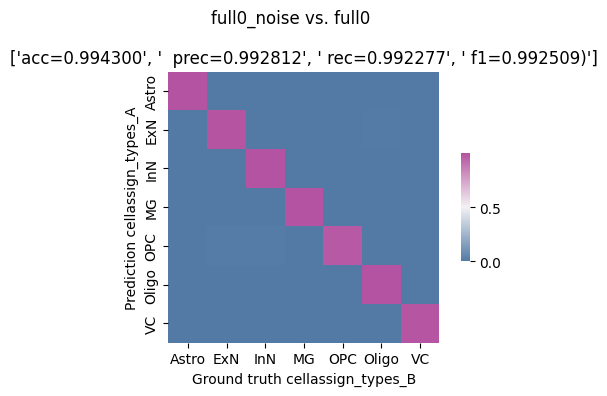

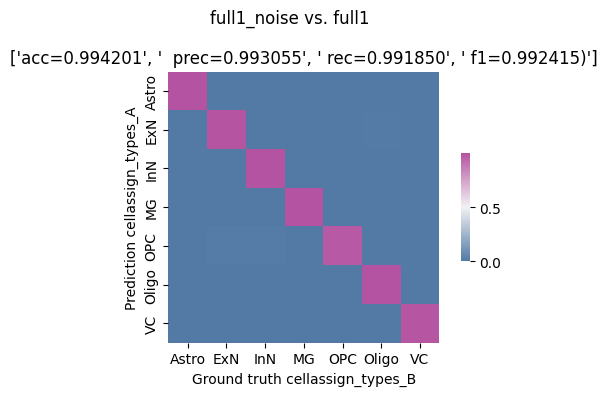

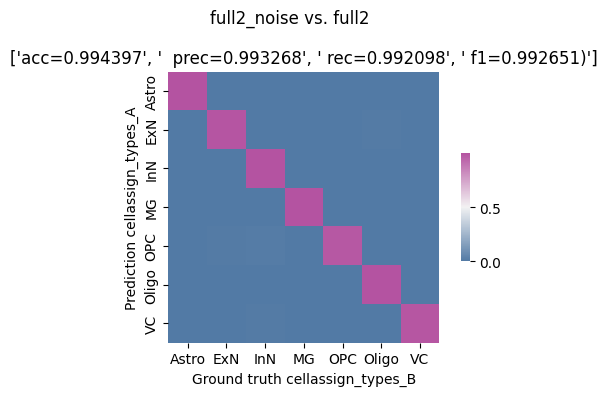

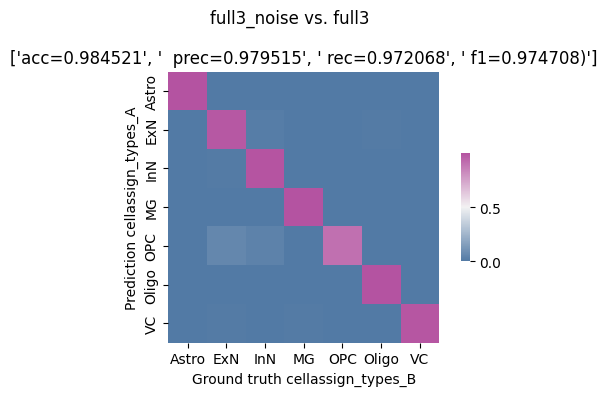

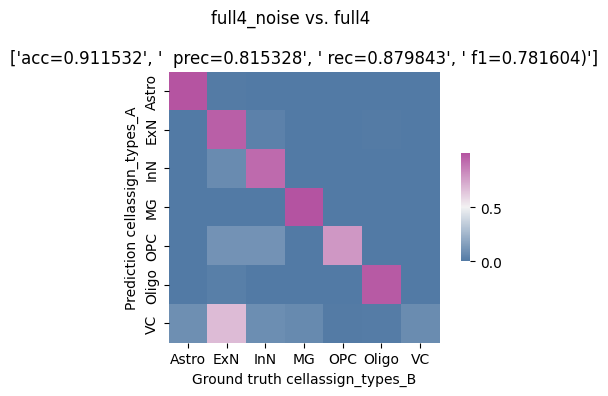

In [16]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6

for rep in range(5):
    for samp_set in ["full"]:
        noise = "_noise"
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        noise = ""
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

For the "clean" samples choosing batch correction with continuous covariates (`noise`) doesn't make much of a difference.  However for the "full" set of samples it is crucial.  It seems reasonabl the the "dirty" samples drive this need for more involved batch correction.


### Vanilla and "Noise" sets  Clean vs. Full ("_noise")

 N samples full0= 2012744, N samples full1= 2012744
   (underscore `_` indicates samples matched to full0 samples)
                   full0pct   full1pct  full1pct_   full0  full1_
cellassign_types                                                 
ExN               36.945434  36.929982  36.929982  743617  743306
Oligo             36.631882  36.630689  36.630689  737306  737282
Astro              8.401963   8.421687   8.421687  169110  169507
InN                7.760152   7.759308   7.759308  156192  156175
OPC                5.822449   5.818326   5.818326  117191  117108
MG                 4.071159   4.072947   4.072947   81942   81978
VC                 0.366962   0.367061   0.367061    7386    7388


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1= 2012744, N samples full2= 2012744
   (underscore `_` indicates samples matched to full1 samples)
                   full1pct   full2pct  full2pct_   full1  full2_
cellassign_types                                                 
ExN               36.929982  36.899129  36.899129  743306  742685
Oligo             36.630689  36.645147  36.645147  737282  737573
Astro              8.421687   8.426109   8.426109  169507  169596
InN                7.759308   7.761891   7.761891  156175  156227
OPC                5.818326   5.822201   5.822201  117108  117186
MG                 4.072947   4.079158   4.079158   81978   82103
VC                 0.367061   0.366366   0.366366    7388    7374


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2= 2012744, N samples full3= 2012744
   (underscore `_` indicates samples matched to full2 samples)
                   full2pct   full3pct  full3pct_   full2  full3_
cellassign_types                                                 
ExN               36.899129  39.311656  39.311656  742685  791243
Oligo             36.645147  36.668747  36.668747  737573  738048
Astro              8.426109   8.388747   8.388747  169596  168844
InN                7.761891   4.883930   4.883930  156227   98301
OPC                5.822201   6.310142   6.310142  117186  127007
MG                 4.079158   4.066240   4.066240   82103   81843
VC                 0.366366   0.370539   0.370539    7374    7458


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3= 2012744, N samples full4= 2012744
   (underscore `_` indicates samples matched to full3 samples)
                   full3pct   full4pct  full4pct_   full3  full4_
cellassign_types                                                 
ExN               39.311656  39.311656  39.311656  791243  791243
Oligo             36.668747  36.668747  36.668747  738048  738048
Astro              8.388747   8.388747   8.388747  168844  168844
OPC                6.310142   6.310142   6.310142  127007  127007
InN                4.883930   4.883930   4.883930   98301   98301
MG                 4.066240   4.066240   4.066240   81843   81843
VC                 0.370539   0.370539   0.370539    7458    7458


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full4= 2012744, N samples full5= 2012744
   (underscore `_` indicates samples matched to full4 samples)
                   full4pct   full5pct  full5pct_   full4  full5_
cellassign_types                                                 
ExN               39.311656  39.311656  39.311656  791243  791243
Oligo             36.668747  36.668747  36.668747  738048  738048
Astro              8.388747   8.388747   8.388747  168844  168844
OPC                6.310142   6.310142   6.310142  127007  127007
InN                4.883930   4.883930   4.883930   98301   98301
MG                 4.066240   4.066240   4.066240   81843   81843
VC                 0.370539   0.370539   0.370539    7458    7458


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full5= 2012744, N samples full6= 2012744
   (underscore `_` indicates samples matched to full5 samples)
                   full5pct   full6pct  full6pct_   full5  full6_
cellassign_types                                                 
ExN               39.311656  39.311656  39.311656  791243  791243
Oligo             36.668747  36.668747  36.668747  738048  738048
Astro              8.388747   8.388747   8.388747  168844  168844
OPC                6.310142   6.310142   6.310142  127007  127007
InN                4.883930   4.883930   4.883930   98301   98301
MG                 4.066240   4.066240   4.066240   81843   81843
VC                 0.370539   0.370539   0.370539    7458    7458


/var/tmp/ipykernel_168460/1533542664.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


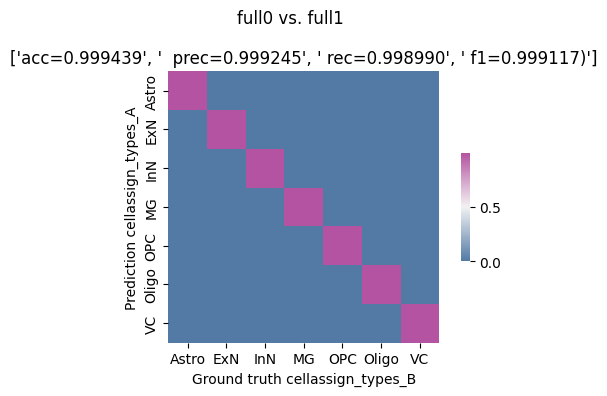

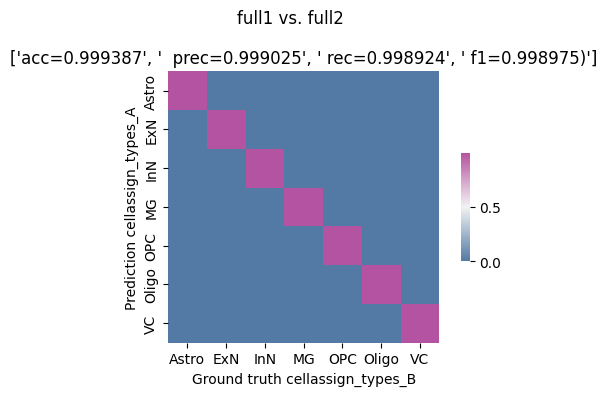

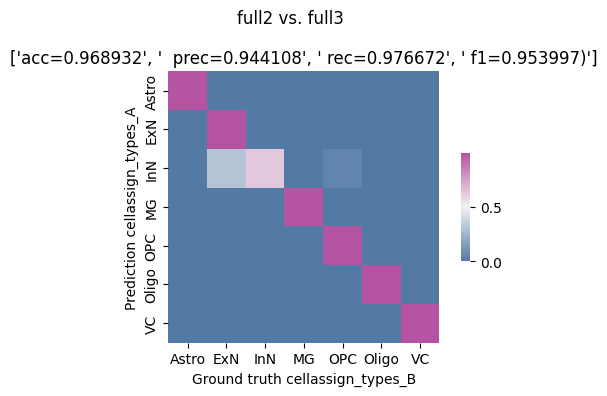

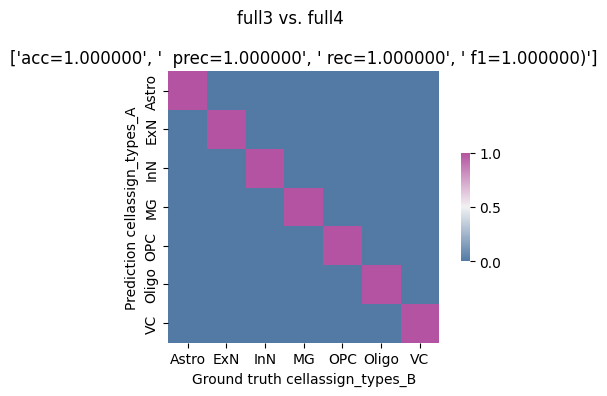

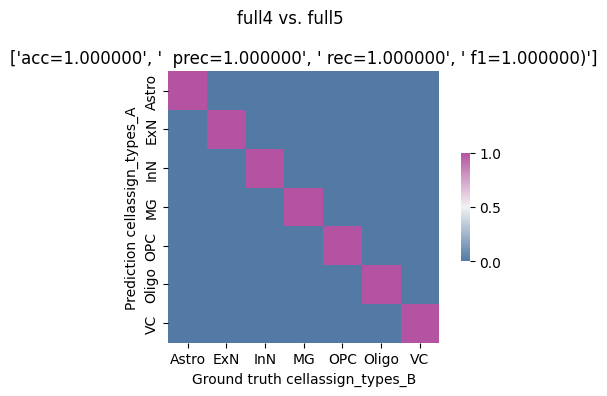

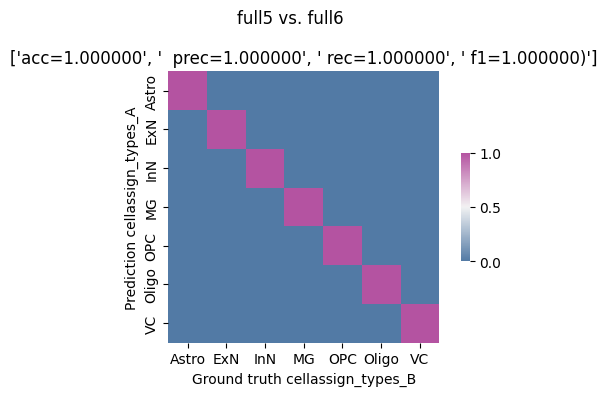

In [17]:
samp_set = "full"
samp_set = "clean"
noise = "_noise"
noise = ""
rep = 6
samp_set = "full"

for rep in range(6):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    B = f"{samp_set}{rep+1}{noise}"
    filenB = root_path / f"testing/{B}_predictions.feather"
    predictionsB = pd.read_feather(filenB)

    merged_predictions = pd.merge(
        predictionsA, predictionsB, on="cell", how="left", suffixes=("_A", "_B")
    )
    print_count_subset(predictionsA, predictionsB, labs=[A, B])
    plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

#### implications

_Without_ the `noise` batch correction the full dataset (presumably driven by the "dirty" samples) classify many of the neurons as "fibrous_astrocytes" and there is very poor correspondence between the "clean" samples when fit _with_ the "dirty" samples versus alone.  However _with_ batch correction including continuous `noise` covariates (`["doublet_score", "pct_counts_mt", "pct_counts_rb"]` ) the cell type assignments are overal quite accurate between the two datasets.   The notable exception are the "unknown", "t_cell" and "b_cell" assigned cells.  However these represent extremely rare cell types according to this dataset and assignment.

## conclusions

For "ground truth" assignments fitting cellassign with the continusous `noise` covariates on the "full" dataset should give us the most reasonable ground truth. 

Next steps:
- consider further simplified 
- consider alternate ground truth assignment methods which might leverage additional priors.  Here we are only constrained by consistency and the assumed marker genes
- estimate baseline performance of this ground truth designation procedure by analyzing the stability of assignments with different seed values. 

## repeatability...

In [9]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full"]:
    for noise in ["_noise", ""]:
        rep = 0
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 1
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

ImportError: Missing optional dependency 'pyarrow'.  Use pip or conda to install pyarrow.

### results

Seems to be some great confusion between immune cells:  microglia, t_cell, b_cell, for the clean dataset without the noise parameters.



 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                        full1_noisepct  full2_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.430018       36.419634       733243   
glutamatergic                34.422361       31.830973       692834   
gabergic                      7.581689       10.434809       152600   
protoplasmic_astrocyte        6.306366        6.331655       126931   
opc                           5.936224        5.635441       119481   
microglia                     5.121963        5.132794       103092   
fibrous_astrocyte             2.679625        2.687674        53934   
endothelial                   1.188179        1.195780        23915   
pericyte                      0.328010        0.326221         6602   
t_cell                        0.005018        0.004223          101   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean2_noise= 840710
                        clean1_noisepct  clean2_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.905544        343071   
glutamatergic                 30.481022         4.470864        256257   
gabergic                       7.313342        30.068989         61484   
opc                            5.739791         8.767946         48255   
protoplasmic_astrocyte         5.684838         5.622985         47793   
microglia                      5.592416         5.608831         47016   
fibrous_astrocyte              3.130330         3.126881         26317   
endothelial                    0.962401         0.960260          8091   
pericyte                       0.287376         0.328651          2416   
b_cell                         0.000714         0.001546             6   
unknown                        0.000357         

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1= 840710, N samples clean2= 840710
                        clean1pct  clean2pct  clean1    clean2
cellassign_types                                              
oligo                   40.974058  41.047805  344473  345093.0
glutamatergic           32.370258  22.801323  272140  191693.0
opc                      6.067134   5.586944   51007   46970.0
protoplasmic_astrocyte   5.702085   5.754065   47938   48375.0
microglia                5.599791   5.611091   47078   47173.0
gabergic                 4.742182  14.655589   39868  123211.0
fibrous_astrocyte        3.222395   3.220016   27091   27071.0
endothelial              0.945748   0.959189    7951    8064.0
pericyte                 0.368736   0.361361    3100    3038.0
t_cell                   0.005828   0.002617      49      22.0
b_cell                   0.001546        NaN      13       NaN
unknown                  0.000238        NaN       2       NaN


/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


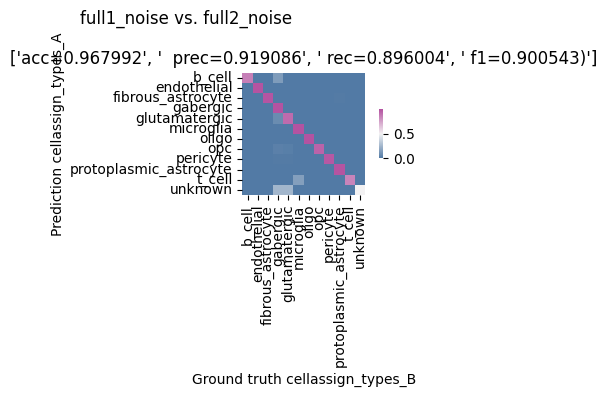

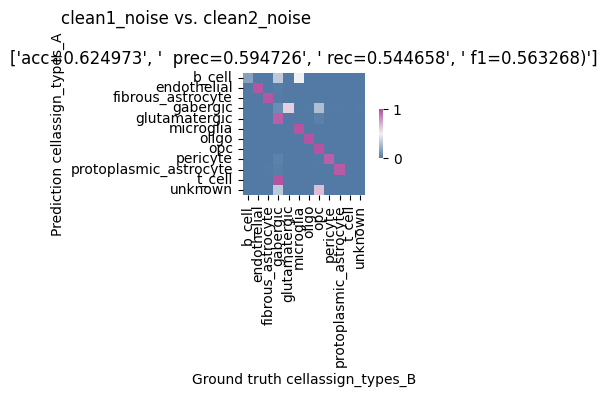

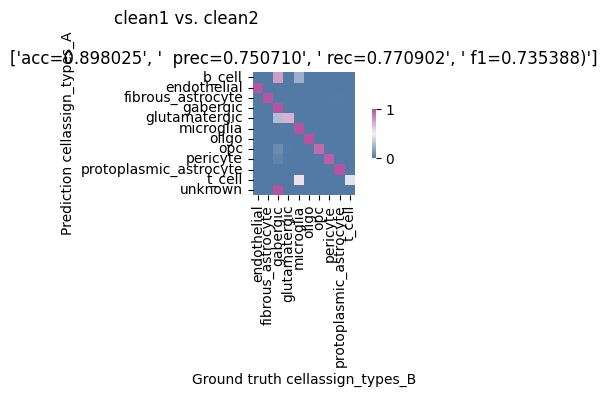

In [11]:
# full nooise, clean noise, clean naive
# compare seed 0 and seed 1

for samp_set in ["full", "clean"]:
    for noise in ["_noise", ""]:
        if samp_set == "full" and noise == "":
            continue
        rep = 1
        A = f"{samp_set}{rep}{noise}"
        filenA = root_path / f"testing/{A}_predictions.feather"
        predictionsA = pd.read_feather(filenA)

        rep = 2
        B = f"{samp_set}{rep}{noise}"
        filenB = root_path / f"testing/{B}_predictions.feather"
        predictionsB = pd.read_feather(filenB)

        merged_predictions = pd.merge(
            predictionsA, predictionsB, on="cell", how="right", suffixes=("_A", "_B")
        )
        print_count_group(predictionsA, predictionsB, labs=[A, B])
        plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

 N samples full0_noise= 2012744, N samples full1_noise= 2012744
                        full0_noisepct  full1_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.439309       36.430018       733430   
glutamatergic                34.417343       34.422361       692733   
gabergic                      7.594259        7.581689       152853   
protoplasmic_astrocyte        6.308800        6.306366       126980   
opc                           5.909644        5.936224       118946   
microglia                     5.124994        5.121963       103153   
fibrous_astrocyte             2.675601        2.679625        53853   
endothelial                   1.195433        1.188179        24061   
pericyte                      0.329600        0.328010         6634   
t_cell                        0.004770        0.005018           96   
b_cell                        0.000248        0.000348            5   

            

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full2_noise= 2012744
                        full0_noisepct  full2_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.439309       36.419634       733430   
glutamatergic                34.417343       31.830973       692733   
gabergic                      7.594259       10.434809       152853   
protoplasmic_astrocyte        6.308800        6.331655       126980   
opc                           5.909644        5.635441       118946   
microglia                     5.124994        5.132794       103153   
fibrous_astrocyte             2.675601        2.687674        53853   
endothelial                   1.195433        1.195780        24061   
pericyte                      0.329600        0.326221         6634   
t_cell                        0.004770        0.004223           96   
b_cell                        0.000248        0.000348            5   

            

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full0_noise= 2012744, N samples full3_noise= 2012744
                        full0_noisepct  full3_noisepct  full0_noise  \
cellassign_types                                                      
oligo                        36.439309       36.464846       733430   
glutamatergic                34.417343       34.377149       692733   
gabergic                      7.594259        7.587850       152853   
protoplasmic_astrocyte        6.308800        6.304031       126980   
opc                           5.909644        5.924648       118946   
microglia                     5.124994        5.124894       103153   
fibrous_astrocyte             2.675601        2.691997        53853   
endothelial                   1.195433        1.191508        24061   
pericyte                      0.329600        0.328060         6634   
t_cell                        0.004770        0.004670           96   
b_cell                        0.000248        0.000149            5   

            

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full0_noise= 2012744
                        full1_noisepct  full0_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.430018       36.439309       733243   
glutamatergic                34.422361       34.417343       692834   
gabergic                      7.581689        7.594259       152600   
protoplasmic_astrocyte        6.306366        6.308800       126931   
opc                           5.936224        5.909644       119481   
microglia                     5.121963        5.124994       103092   
fibrous_astrocyte             2.679625        2.675601        53934   
endothelial                   1.188179        1.195433        23915   
pericyte                      0.328010        0.329600         6602   
t_cell                        0.005018        0.004770          101   
b_cell                        0.000348        0.000248            7   
unknown      

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full2_noise= 2012744
                        full1_noisepct  full2_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.430018       36.419634       733243   
glutamatergic                34.422361       31.830973       692834   
gabergic                      7.581689       10.434809       152600   
protoplasmic_astrocyte        6.306366        6.331655       126931   
opc                           5.936224        5.635441       119481   
microglia                     5.121963        5.132794       103092   
fibrous_astrocyte             2.679625        2.687674        53934   
endothelial                   1.188179        1.195780        23915   
pericyte                      0.328010        0.326221         6602   
t_cell                        0.005018        0.004223          101   
b_cell                        0.000348        0.000348            7   
unknown      

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full1_noise= 2012744, N samples full3_noise= 2012744
                        full1_noisepct  full3_noisepct  full1_noise  \
cellassign_types                                                      
oligo                        36.430018       36.464846       733243   
glutamatergic                34.422361       34.377149       692834   
gabergic                      7.581689        7.587850       152600   
protoplasmic_astrocyte        6.306366        6.304031       126931   
opc                           5.936224        5.924648       119481   
microglia                     5.121963        5.124894       103092   
fibrous_astrocyte             2.679625        2.691997        53934   
endothelial                   1.188179        1.191508        23915   
pericyte                      0.328010        0.328060         6602   
t_cell                        0.005018        0.004670          101   
b_cell                        0.000348        0.000149            7   
unknown      

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full0_noise= 2012744
                        full2_noisepct  full0_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.419634       36.439309       733034   
glutamatergic                31.830973       34.417343       640676   
gabergic                     10.434809        7.594259       210026   
protoplasmic_astrocyte        6.331655        6.308800       127440   
opc                           5.635441        5.909644       113427   
microglia                     5.132794        5.124994       103310   
fibrous_astrocyte             2.687674        2.675601        54096   
endothelial                   1.195780        1.195433        24068   
pericyte                      0.326221        0.329600         6566   
t_cell                        0.004223        0.004770           85   
unknown                       0.000447             NaN            9   
b_cell       

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full1_noise= 2012744
                        full2_noisepct  full1_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.419634       36.430018       733034   
glutamatergic                31.830973       34.422361       640676   
gabergic                     10.434809        7.581689       210026   
protoplasmic_astrocyte        6.331655        6.306366       127440   
opc                           5.635441        5.936224       113427   
microglia                     5.132794        5.121963       103310   
fibrous_astrocyte             2.687674        2.679625        54096   
endothelial                   1.195780        1.188179        24068   
pericyte                      0.326221        0.328010         6566   
t_cell                        0.004223        0.005018           85   
unknown                       0.000447        0.000199            9   
b_cell       

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full2_noise= 2012744, N samples full3_noise= 2012744
                        full2_noisepct  full3_noisepct  full2_noise  \
cellassign_types                                                      
oligo                        36.419634       36.464846       733034   
glutamatergic                31.830973       34.377149       640676   
gabergic                     10.434809        7.587850       210026   
protoplasmic_astrocyte        6.331655        6.304031       127440   
opc                           5.635441        5.924648       113427   
microglia                     5.132794        5.124894       103310   
fibrous_astrocyte             2.687674        2.691997        54096   
endothelial                   1.195780        1.191508        24068   
pericyte                      0.326221        0.328060         6566   
t_cell                        0.004223        0.004670           85   
unknown                       0.000447        0.000199            9   
b_cell       

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full0_noise= 2012744
                        full3_noisepct  full0_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.464846       36.439309       733944   
glutamatergic                34.377149       34.417343       691924   
gabergic                      7.587850        7.594259       152724   
protoplasmic_astrocyte        6.304031        6.308800       126884   
opc                           5.924648        5.909644       119248   
microglia                     5.124894        5.124994       103151   
fibrous_astrocyte             2.691997        2.675601        54183   
endothelial                   1.191508        1.195433        23982   
pericyte                      0.328060        0.329600         6603   
t_cell                        0.004670        0.004770           94   
unknown                       0.000199             NaN            4   
b_cell       

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full1_noise= 2012744
                        full3_noisepct  full1_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.464846       36.430018       733944   
glutamatergic                34.377149       34.422361       691924   
gabergic                      7.587850        7.581689       152724   
protoplasmic_astrocyte        6.304031        6.306366       126884   
opc                           5.924648        5.936224       119248   
microglia                     5.124894        5.121963       103151   
fibrous_astrocyte             2.691997        2.679625        54183   
endothelial                   1.191508        1.188179        23982   
pericyte                      0.328060        0.328010         6603   
t_cell                        0.004670        0.005018           94   
unknown                       0.000199        0.000199            4   
b_cell       

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples full3_noise= 2012744, N samples full2_noise= 2012744
                        full3_noisepct  full2_noisepct  full3_noise  \
cellassign_types                                                      
oligo                        36.464846       36.419634       733944   
glutamatergic                34.377149       31.830973       691924   
gabergic                      7.587850       10.434809       152724   
protoplasmic_astrocyte        6.304031        6.331655       126884   
opc                           5.924648        5.635441       119248   
microglia                     5.124894        5.132794       103151   
fibrous_astrocyte             2.691997        2.687674        54183   
endothelial                   1.191508        1.195780        23982   
pericyte                      0.328060        0.326221         6603   
t_cell                        0.004670        0.004223           94   
unknown                       0.000199        0.000447            4   
b_cell       

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


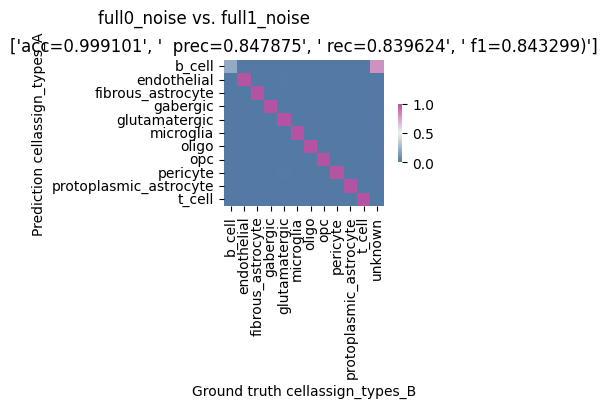

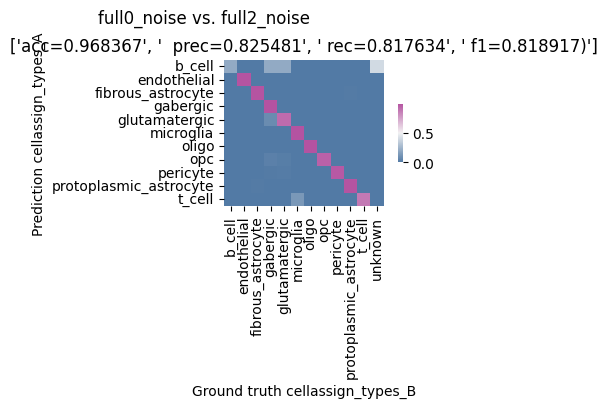

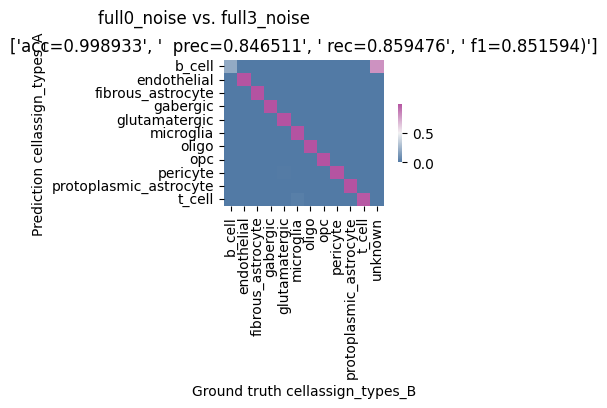

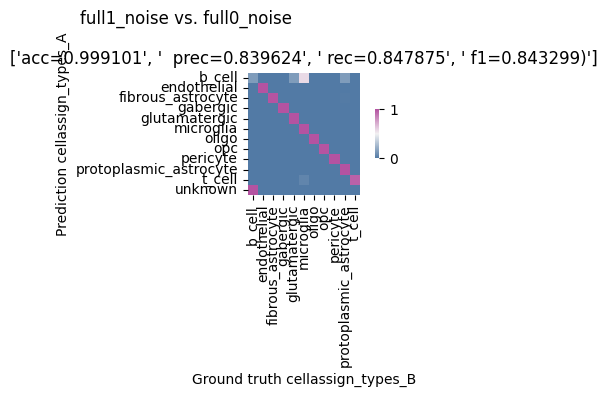

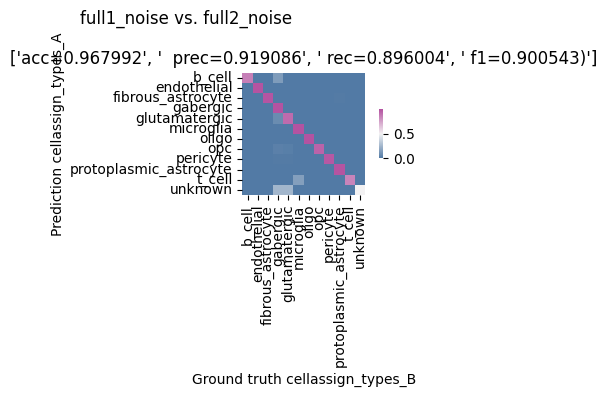

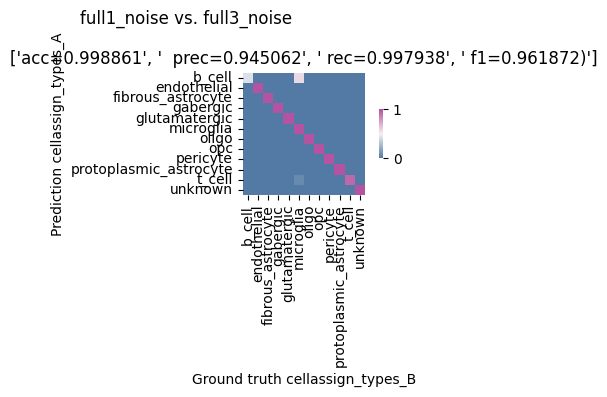

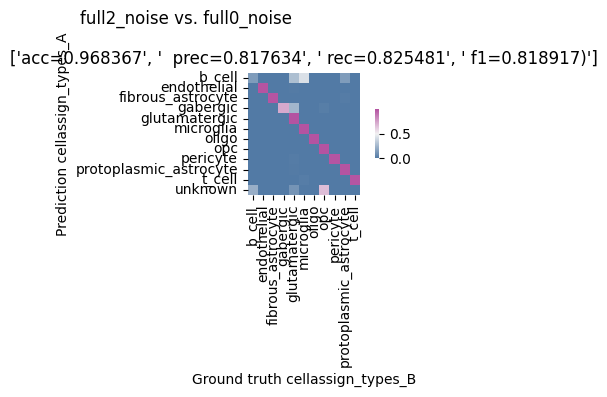

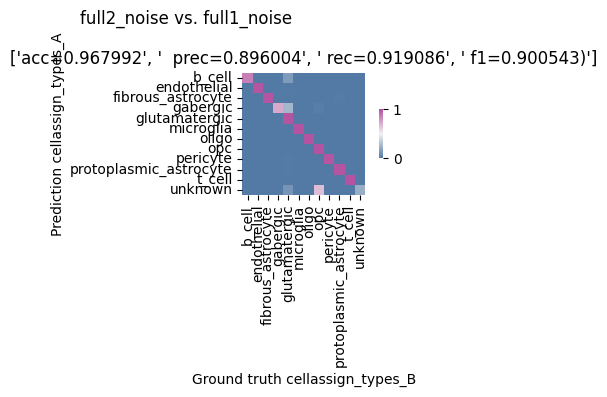

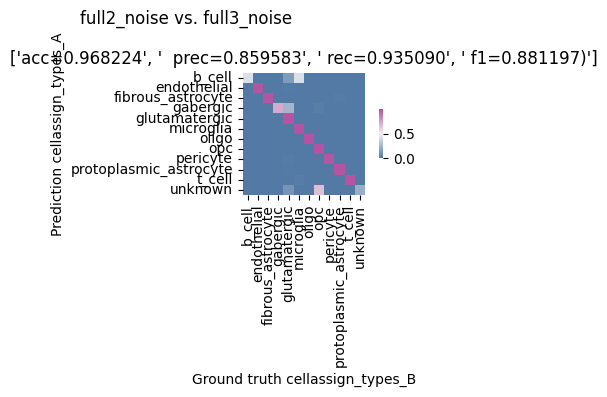

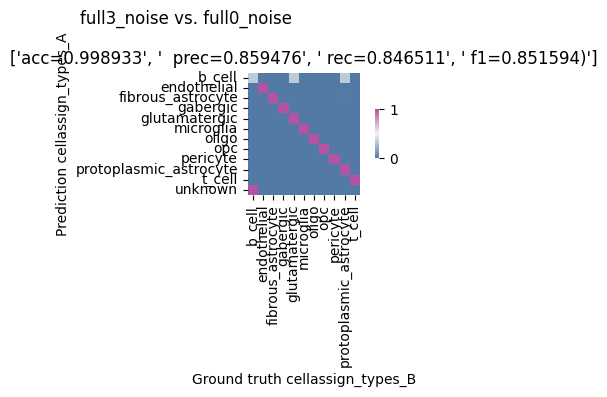

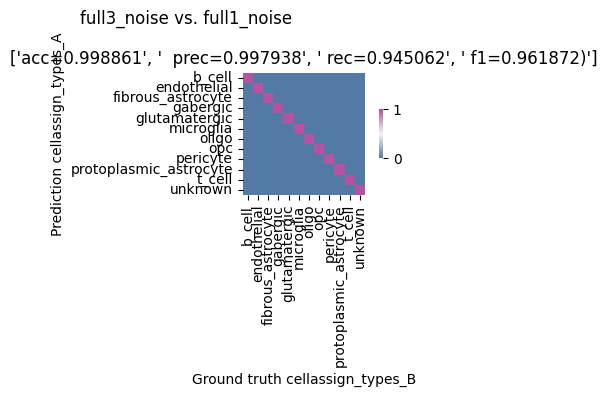

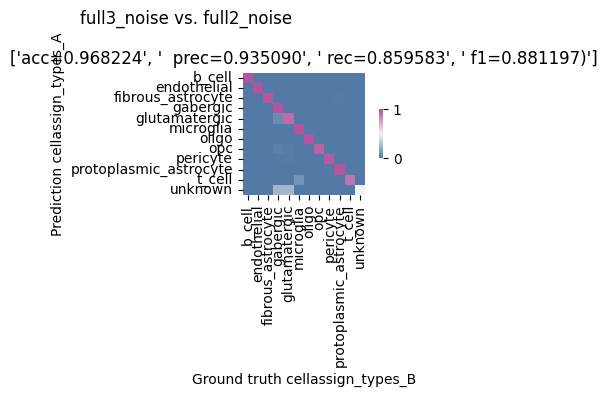

In [13]:
samp_set = "full"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

In [14]:
samp_set = "full"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)

counts 0-3
                        full0_noise  full1_noise  full2_noise  full3_noise
cellassign_types                                                          
oligo                        733430       733243       733034       733944
glutamatergic                692733       692834       640676       691924
gabergic                     152853       152600       210026       152724
protoplasmic_astrocyte       126980       126931       127440       126884
opc                          118946       119481       113427       119248
microglia                    103153       103092       103310       103151
fibrous_astrocyte             53853        53934        54096        54183
endothelial                   24061        23915        24068        23982
pericyte                       6634         6602         6566         6603
t_cell                           96          101           85           94
b_cell                            5            7            7            3
pcts 0-3
     

In [15]:
samp_set = "clean"
noise = "_noise"

rep = 0

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)
    for rep2 in range(4):
        if rep == rep2:
            continue
        else:
            B = f"{samp_set}{rep2}{noise}"
            filenB = root_path / f"testing/{B}_predictions.feather"
            predictionsB = pd.read_feather(filenB)
            merged_predictions = pd.merge(
                predictionsA,
                predictionsB,
                on="cell",
                how="right",
                suffixes=("_A", "_B"),
            )
            print_count_group(predictionsA, predictionsB, labs=[A, B])
            plot_confusion(merged_predictions, title_caption=f"{A} vs. {B}")

 N samples clean0_noise= 840710, N samples clean1_noise= 840710
                        clean0_noisepct  clean1_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.807294        343615   
glutamatergic                 33.245828        30.481022        279501   
opc                            8.348063         5.739791         70183   
protoplasmic_astrocyte         5.645823         5.684838         47465   
microglia                      5.596936         5.592416         47054   
fibrous_astrocyte              3.152454         3.130330         26503   
gabergic                       1.790748         7.313342         15055   
endothelial                    0.977626         0.962401          8219   
pericyte                       0.362908         0.287376          3051   
t_cell                         0.003925         0.000119            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean2_noise= 840710
                        clean0_noisepct  clean2_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.905544        343615   
glutamatergic                 33.245828         4.470864        279501   
opc                            8.348063         8.767946         70183   
protoplasmic_astrocyte         5.645823         5.622985         47465   
microglia                      5.596936         5.608831         47054   
fibrous_astrocyte              3.152454         3.126881         26503   
gabergic                       1.790748        30.068989         15055   
endothelial                    0.977626         0.960260          8219   
pericyte                       0.362908         0.328651          3051   
t_cell                         0.003925         0.005591            33   
b_cell                         0.003687         

/home/ergonyc/mambaforge/envs/scib_nb2/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean0_noise= 840710, N samples clean3_noise= 840710
                        clean0_noisepct  clean3_noisepct  clean0_noise  \
cellassign_types                                                         
oligo                         40.872001        40.898764        343615   
glutamatergic                 33.245828        25.743241        279501   
opc                            8.348063         5.661524         70183   
protoplasmic_astrocyte         5.645823         5.684957         47465   
microglia                      5.596936         5.594081         47054   
fibrous_astrocyte              3.152454         3.166609         26503   
gabergic                       1.790748        11.987844         15055   
endothelial                    0.977626         0.968705          8219   
pericyte                       0.362908         0.288328          3051   
t_cell                         0.003925         0.005591            33   
b_cell                         0.003687         

/tmp/ipykernel_1514653/704093550.py:82: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  confusion_matrix /= confusion_matrix.sum(1).ravel().reshape(-1, 1)


 N samples clean1_noise= 840710, N samples clean0_noise= 840710
                        clean1_noisepct  clean0_noisepct  clean1_noise  \
cellassign_types                                                         
oligo                         40.807294        40.872001        343071   
glutamatergic                 30.481022        33.245828        256257   
gabergic                       7.313342         1.790748         61484   
opc                            5.739791         8.348063         48255   
protoplasmic_astrocyte         5.684838         5.645823         47793   
microglia                      5.592416         5.596936         47016   
fibrous_astrocyte              3.130330         3.152454         26317   
endothelial                    0.962401         0.977626          8091   
pericyte                       0.287376         0.362908          2416   
b_cell                         0.000714         0.003687             6   
unknown                        0.000357         

In [ ]:
samp_set = "clean"
noise = "_noise"

rep = 0
summary = pd.DataFrame()
summary_pct = pd.DataFrame()

for rep in range(4):
    A = f"{samp_set}{rep}{noise}"
    filenA = root_path / f"testing/{A}_predictions.feather"
    predictionsA = pd.read_feather(filenA)

    summary_pct[A] = (
        100 * predictionsA.cellassign_types.value_counts() / predictionsA.shape[0]
    )
    summary[A] = predictionsA.cellassign_types.value_counts()


print(f"counts 0-3")
print(summary)
print(f"pcts 0-3")
print(summary_pct)